# Programación MINLP Ejemplo de Grossmann
### Elaborado por Daniel Ovalle - 201631778
### Asesorado por Jorge Mario Gómez y Camilo Gómez

El objetivo de este notebook es abordar el problema de pooling que expone Grossmann desde la formulación MINLP.

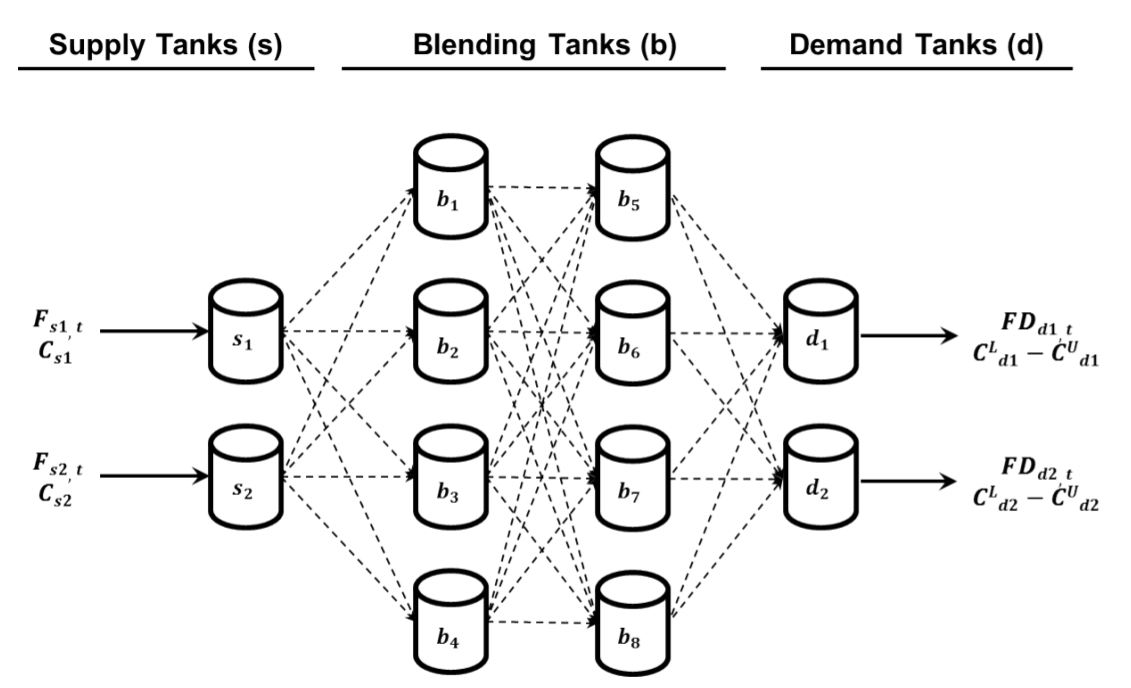

### Sets:
$N=$ Total number of tanks <br>
$A=$ Total number of feasible arcs <br>
$B=$ Blending tanks <br>
$S=$ Supply tanks <br>
$D=$ Demand tanks <br>
$Q=$ Specifications <br>
$T=$ Time periods <br>

### Continuous Variables: 
$F_{nn',t}=$ Flow between tanks $n$ and $n'$ at the end of time $t$<br>
$FD_{d,t}=$ Demand flow from tanks $d$ at time $t$ <br>
$I_{n,t}=$ Inventory in tank $n$ at the end of time $t$ <br>
$C_{q,b,t}=$ Specification $q$ in tank $b$ at the end of time $t$ <br>

### Binary Variables:
$X_{nn',t}=$ Indicates the existence of flow between tanks $n$ and $n'$ at the end of time $t$ <br>

### Parameters:
$I^0_n=$ Initial inventory for tank $n$ <br>
$C^0_{q,b}=$ Initial values for the specifications $q$ in tank $b$ <br>
$F^{IN}_{s,t}=$ Incoming supply flows enter tank $s$ at time $t$ <br>
$C^{IN}_{q,s}=$ Specification $q$ in supply flow to tank $s$ <br>
$\hat{C}^0_{q,r}$ Specification $q$ in source $r$ <br>
$[FD^L_{d,t} , FD^U_{d,t}]=$ Bounds on demand flow from tanks $d$ at time $t$ <br>
$[C^L_{q,d} , C^U_{q,d}]=$ Bounds on specification $q$ in demand tank $d$ <br>
$[I^L_n , I^U_n]=$ Bounds on inventory for tank $n$ <br>
$[F^L_{nn'} , F^U_{nn'}]=$ Bounds on flow between tank $n$ and $n'$ <br>
$\beta^T_s=$ Costs for the supply flow for tank $s$ <br>
$\beta^T_d=$ Prices for demand flow for tank $d$ <br>
$\alpha^N_{nn'}=$ Fixed costs for flow from tank $n$ to tnak $n'$ <br>
$\beta^N_{nn'}=$ Variable costs for flow from tank $n$ to tnak $n'$ <br>

In [23]:
# Import all

import numpy as np
import pandas as pd
import networkx as nx
from gurobipy import *
import matplotlib.pyplot as plt
import time as time
import random as random

In [24]:
# Create Sets
B = [3,4,5,6,7,8,9,10]
S = [1,2]
D = [11,12]
N = S + B + D

B1 = [3,4,5,6]
B2 = [7,8,9,10]
Nb = S + B1

Asn = {(s,n):1 for s in S for n in B1}
And = {(n,d):1 for n in B2 for d in D}
Abb = {(b1,b2):1 for b1 in B1 for b2 in B2}
Asd = {(s,d):1 for s in S for d in D}
A = {}
for i in (Asn, Abb, And, Asd): 
    A.update(i)
    
Anb ={}
for i in (Asn, Abb):
    Anb.update(i)
        
Q = ['A']
T = list(range(1,7))

BM = 30
BMC = 2
BM1 = 30
BM2 = BM

#Create given Parameters
I0_b = {b:0 for b in B}  
C0_qb = {(q,b):0 for q in Q for b in B}
IU_s = {s:0 for s in S}
IU_d = {d:0 for d in D}
IU_b1 = {b1:30 for b1 in B1}
IU_b2 = {b2:20 for b2 in B2}
IU_b = {}
for i in (IU_b1, IU_b2): 
    IU_b.update(i)
FU_nn = {nn:30 for nn in A}
alphaN_nn = {nn:0.1 for nn in A}
CIN_qs = {('A',1):0.06, ('A',2):0.26}
FIN_st = {(1,1):10, (1,2):10, (1,3):10, (1,4):0, (1,5):0, (1,6):0, (2,1):30, (2,2):30, (2,3):30, (2,4):0, (2,5):0, (2,6):0}
betaT_s = {s:0 for s in S}
CL_qd = {(q,d):0 for q in Q for d in D}
CU_qd = {('A',11):0.16, ('A',12):1}
FDL_dt = {(11,1):0, (11,2):0, (11,3):15, (11,4):15, (11,5):15, (11,6):15, (12,1):0, (12,2):0, (12,3):15, (12,4):15, (12,5):15, (12,6):15}
betaT_d = {11:2 , 12:1}

#Create other Parameters
I0_s = {s:0 for s in S}
I0_d = {d:0 for d in D}
I0_n = {}
for i in (I0_s, I0_b, I0_d): 
    I0_n.update(i)
FDU_dt = {(d,t):BM1 for d in D for t in T}
IL_n = {n:0 for n in N}
IU_n = {}
for i in (IU_s, IU_b, IU_d): 
    IU_n.update(i)
FL_nn = {nn:10 for nn in A}
betaN_nn = {nn:0 for nn in A}
CL_q = {q:0 for q in Q}
CU_q = {q:1 for q in Q}

In [25]:
BM = Fmax
BMC = 1
BM1 = Fmax
BM2 = BM

# Model
m1 = Model("T3SD1Q1P12-GDP (G0)")
m1.setParam('OutputFlag', 1)
m1.setParam('NonConvex', 2)
m1.setParam('TimeLimit', 10)
m1.setParam('MIQCPMethod', 0)
m1.setParam('MIPGap', 0.005)

# Variables
F = {(nn,t):m1.addVar(vtype=GRB.CONTINUOUS,name="F_"+str((nn,t))) for nn in A for t in T}
FD = {(d,t):m1.addVar(vtype=GRB.CONTINUOUS,name="FD_"+str((d,t))) for d in D for t in T}
I = {(n,t):m1.addVar(vtype=GRB.CONTINUOUS,name="I_"+str((n,t))) for n in N for t in T}
C = {(q,b,t):m1.addVar(vtype=GRB.CONTINUOUS,name="C_"+str((q,b,t))) for q in Q for b in B for t in T}
X = {(nn,t):m1.addVar(vtype=GRB.BINARY,name="X_"+str((nn,t))) for nn in A for t in T}
YB = {(b,t):m1.addVar(vtype=GRB.BINARY,name="YB_"+str((b,t))) for b in B for t in T}


for t in T:   # Supply tank inventory
    for s in S: 
        if t==1:
            m1.addConstr(I[s,t] == I0_n[s] + FIN_st[s,t] - quicksum(F[(s,n),t] for n in B1) - quicksum(F[(s,d),t] for d in D))
        else:
            m1.addConstr(I[s,t] == I[s,t-1] + FIN_st[s,t] - quicksum(F[(s,n),t] for n in B1) - quicksum(F[(s,d),t] for d in D))
    

    for d in D: # Demand tank inventory
            if t==1:
                m1.addConstr(I[d,t] == I0_n[d] + quicksum(F[(n,d),t] for n in B2) + quicksum(F[(s,d),t] for s in S) - FD[d,t])
            else:
                m1.addConstr(I[d,t] == I[d,t-1] + quicksum(F[(n,d),t] for n in B2) + quicksum(F[(s,d),t] for s in S) - FD[d,t])
#___
    for n in S:   # Flow activation
        for b in B1:
            m1.addConstr(FL_nn[(n,b)] - F[(n,b),t] <= BM * (1 - X[(n,b),t]))
            m1.addConstr(F[(n,b),t] - FU_nn[(n,b)] <= BM * (1 - X[(n,b),t]))
            m1.addConstr(F[(n,b),t] <= BM * X[(n,b),t])

    for n in B1:
        for b in B2:
            m1.addConstr(FL_nn[(n,b)] - F[(n,b),t] <= BM * (1 - X[(n,b),t]))
            m1.addConstr(F[(n,b),t] - FU_nn[(n,b)] <= BM * (1 - X[(n,b),t]))
            m1.addConstr(F[(n,b),t] <= BM * X[(n,b),t])
#___            
    for s in S:     # SD Flow activation
        for d in D:
            m1.addConstr(FL_nn[(s,d)] - F[(s,d),t] <= BM * (1 - X[(s,d),t]))
            m1.addConstr(F[(s,d),t] - FU_nn[(s,d)] <= BM * (1 - X[(s,d),t]))
            m1.addConstr(F[(s,d),t] <= BM * X[(s,d),t])
            for q in Q:
                m1.addConstr(CL_qd[(q,d)] - CIN_qs[q,s] <= BMC * (1 - X[(s,d),t]))
                m1.addConstr(CIN_qs[q,s] - CU_qd[(q,d)] <= BMC * (1 - X[(s,d),t]))
#___           
    for b in B2:  # Demand Flow activation
        for d in D:
            m1.addConstr(FL_nn[(b,d)] - F[(b,d),t] <= BM * (1 - X[(b,d),t]))
            m1.addConstr(F[(b,d),t] - FU_nn[(b,d)] <= BM * (1 - X[(b,d),t]))
            m1.addConstr(F[(b,d),t] <= BM * X[(b,d),t])
            for q in Q:
                if t > 1:
                    m1.addConstr(CL_qd[(q,d)] - C[q,b,t-1] <= BMC * (1 - X[(b,d),t]))
                    m1.addConstr(C[q,b,t-1] - CU_qd[(q,d)] <= BMC * (1 - X[(b,d),t]))
#___
    for b in B1:  #Blending tank inventory
        if t==1:
            m1.addConstr(I[b,t] <= I0_n[b] + quicksum(F[(s,b),t] for s in S) + BM2 * (1 - YB[b,t]))
            m1.addConstr(I[b,t] >= I0_n[b] + quicksum(F[(s,b),t] for s in S) - BM2 * (1 - YB[b,t]))
            m1.addConstr(I[b,t] <= I0_n[b] - quicksum(F[(b,n),t] for n in B2) + BM2 * YB[b,t])
            m1.addConstr(I[b,t] >= I0_n[b] - quicksum(F[(b,n),t] for n in B2) - BM2 * YB[b,t])
        else:
            m1.addConstr(I[b,t] <= I[b,t-1] + quicksum(F[(s,b),t] for s in S) + BM2 * (1 - YB[b,t]))
            m1.addConstr(I[b,t] >= I[b,t-1] + quicksum(F[(s,b),t] for s in S) - BM2 * (1 - YB[b,t]))
            m1.addConstr(I[b,t] <= I[b,t-1] - quicksum(F[(b,n),t] for n in B2) + BM2 * YB[b,t])
            m1.addConstr(I[b,t] >= I[b,t-1] - quicksum(F[(b,n),t] for n in B2) - BM2 * YB[b,t])
        for q in Q:
            if t==1:
                m1.addConstr(I[b,t] * C[q,b,t] <= I0_n[b] * C0_qb[q,b] + quicksum(F[(s,b),t] * CIN_qs[q,s]  for s in S) + BM2 * (1 - YB[b,t]))
                m1.addConstr(I[b,t] * C[q,b,t] >= I0_n[b] * C0_qb[q,b] + quicksum(F[(s,b),t] * CIN_qs[q,s]  for s in S) - BM2 * (1 - YB[b,t]))
            else:
                m1.addConstr(I[b,t] * C[q,b,t] <= I[b,t-1] * C[q,b,t-1] + quicksum(F[(s,b),t] * CIN_qs[q,s]  for s in S) + BM2 * (1 - YB[b,t]))
                m1.addConstr(I[b,t] * C[q,b,t] >= I[b,t-1] * C[q,b,t-1] + quicksum(F[(s,b),t] * CIN_qs[q,s]  for s in S) - BM2 * (1 - YB[b,t]))
                m1.addConstr(C[q,b,t] <= C[q,b,t-1] + BMC * YB[b,t])
                m1.addConstr(C[q,b,t] >= C[q,b,t-1] - BMC * YB[b,t])
                
    for b in B2:
        if t==1:
            m1.addConstr(I[b,t] <= I0_n[b] + quicksum(F[(n,b),t] for n in B1) + BM2 * (1 - YB[b,t]))
            m1.addConstr(I[b,t] >= I0_n[b] + quicksum(F[(n,b),t] for n in B1) - BM2 * (1 - YB[b,t]))
            m1.addConstr(I[b,t] <= I0_n[b] - quicksum(F[(b,d),t] for d in D) + BM2 * YB[b,t])
            m1.addConstr(I[b,t] >= I0_n[b] - quicksum(F[(b,d),t] for d in D) - BM2 * YB[b,t])
        else:
            m1.addConstr(I[b,t] <= I[b,t-1] + quicksum(F[(n,b),t] for n in B1) + BM2 * (1 - YB[b,t]))
            m1.addConstr(I[b,t] >= I[b,t-1] + quicksum(F[(n,b),t] for n in B1) - BM2 * (1 - YB[b,t]))
            m1.addConstr(I[b,t] <= I[b,t-1] - quicksum(F[(b,d),t] for d in D) + BM2 * YB[b,t])
            m1.addConstr(I[b,t] >= I[b,t-1] - quicksum(F[(b,d),t] for d in D) - BM2 * YB[b,t])
        for q in Q:
            if t==1:
                m1.addConstr(I[b,t] * C[q,b,t] <= I0_n[b] * C0_qb[q,b] + quicksum(F[(n,b),t] * C0_qb[q,n]  for n in B1) + BM2 * (1 - YB[b,t]))
                m1.addConstr(I[b,t] * C[q,b,t] >= I0_n[b] * C0_qb[q,b] + quicksum(F[(n,b),t] * C0_qb[q,n]  for n in B1) - BM2 * (1 - YB[b,t]))
            else:
                m1.addConstr(I[b,t] * C[q,b,t] <= I[b,t-1] * C[q,b,t-1] + quicksum(F[(n,b),t] * C[q,n,t-1]  for n in B1) + BM2 * (1 - YB[b,t]))
                m1.addConstr(I[b,t] * C[q,b,t] >= I[b,t-1] * C[q,b,t-1] + quicksum(F[(n,b),t] * C[q,n,t-1]  for n in B1) - BM2 * (1 - YB[b,t]))
                m1.addConstr(C[q,b,t] <= C[q,b,t-1] + BMC * YB[b,t])
                m1.addConstr(C[q,b,t] >= C[q,b,t-1] - BMC * YB[b,t])
    
#___
    for b in B1:  #Logical relations
        for n in S:
            m1.addConstr(X[(n,b),t] <= YB[b,t])
            
    for b in B2:
        for n in B1:
            m1.addConstr(X[(n,b),t] <= YB[b,t])
#___
    for b in B1:
        for n in B2:
            m1.addConstr(X[(b,n),t] <= 1 - YB[b,t])
            
    for b in B2:
        for n in D:
            m1.addConstr(X[(b,n),t] <= 1 - YB[b,t])
            
    
        
               
    #6 Bounds
    for n in N:
        m1.addConstr(IL_n[n] <= I[n,t])
        m1.addConstr(I[n,t] <= IU_n[n])  
        
    for nn in A:
        m1.addConstr(F[nn,t] >= 0)
                
    for d in D:
        m1.addConstr(FDL_dt[d,t] <= FD[d,t])
        m1.addConstr(FD[d,t] <= FDU_dt[d,t])
        
    for b in B:
        for q in Q:
            m1.addConstr(CL_q[q] <= C[q,b,t])
            m1.addConstr(C[q,b,t] <= CU_q[q])
            
m1.update()

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter TimeLimit to 10800.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter MIQCPMethod to 0
   Prev: -1  Min: -1  Max: 1  Default: -1
Changed value of parameter MIPGap to 0.005
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001


In [26]:

OF = quicksum(quicksum(betaT_d[d] * F[(n,d),t] for d in D for n in B2) + quicksum(betaT_d[d] * F[(s,d),t] for d in D for s in S) -quicksum(alphaN_nn[nn] * X[nn,t] + betaN_nn[nn] * F[nn,t] for nn in A) for t in T)
m1.setObjective(OF,GRB.MAXIMIZE)
tstart = time.process_time()
m1.optimize()
tend = time.process_time()
print(m1.status)
#m1.computeIIS()
#m1.write("aver1.ilp")
print('La utilidad obtenida en la operación es de:',m1.objVal,'$')
print('El tiempo de cómputo fue de',(round(tend - tstart,4)),'segundos')


Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 1864 rows, 612 columns and 4144 nonzeros
Model fingerprint: 0xad5d9b4b
Model has 96 quadratic constraints
Variable types: 348 continuous, 264 integer (264 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [6e-02, 3e+01]
  Objective range  [1e-01, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+01]
  QRHS range       [3e+01, 3e+01]
Presolve removed 1122 rows and 208 columns
Presolve time: 0.04s
Presolved: 1334 rows, 528 columns, 3704 nonzeros
Presolved model has 132 bilinear constraint(s)
Variable types: 348 continuous, 180 integer (180 binary)

Root relaxation: objective 3.580000e+02, 315 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  358.00000    0   66          -  358.00000   

In [27]:
numflujos = 0
for t in T:
    for nn in A:
        if F[nn,t].x >= 0.1:
            numflujos = numflujos + 1
            #print('el flujo',nn,'en el tiempo',t,'debe ser de:',round(F[nn,t].x,2))
print('Número de flujos es de:',numflujos)

numc = 0
for t in T:
    for b in B:
        for q in Q:
            if C[q,b,t].x >= 0.0001:
                numc = numc + 1
                #print('Concentracion del tanque',b,'en el tiempo',t,'es:',round(C[q,b,t].x,4))            
print('Número de concentraciones es de:',numc)  
numx = 0
for t in T:
    for nn in A:
        if X[nn,t].x >= 0.01:
            numx = numx + 1
            #print('Hubo flujo en',nn,'en tiempo',t)
print('Hubo flujo en',numx, 'ocaciones')        
#print(sum(X[nn,t].x for nn in A for t in T))
            

Número de flujos es de: 25
Número de concentraciones es de: 41
Hubo flujo en 25 ocaciones


OK
Los flujos a operar en el tiempo 1 son:


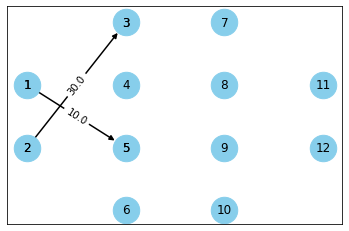


Los flujos a operar en el tiempo 2 son:


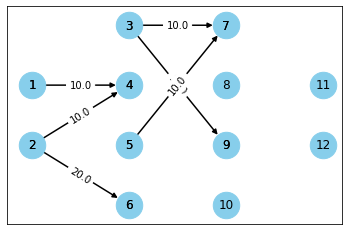


Los flujos a operar en el tiempo 3 son:


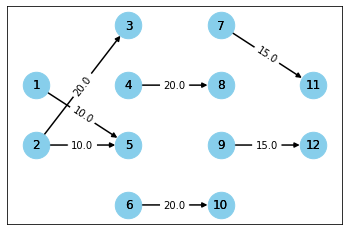

La concentración que salio por 11 es 0.16 que debe estar entre 0 y 0.16
La concentración que salio por 12 es 0.26 que debe estar entre 0 y 1

Los flujos a operar en el tiempo 4 son:


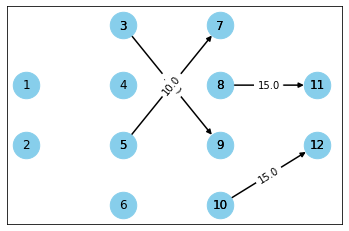

La concentración que salio por 11 es 0.16 que debe estar entre 0 y 0.16
La concentración que salio por 12 es 0.26 que debe estar entre 0 y 1

Los flujos a operar en el tiempo 5 son:


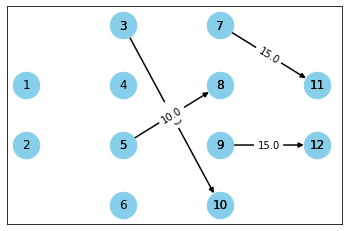

La concentración que salio por 11 es 0.16 que debe estar entre 0 y 0.16
La concentración que salio por 12 es 0.26 que debe estar entre 0 y 1

Los flujos a operar en el tiempo 6 son:


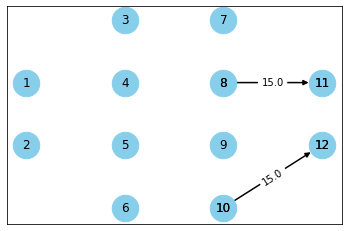

La concentración que salio por 11 es 0.16 que debe estar entre 0 y 0.16
La concentración que salio por 12 es 0.26 que debe estar entre 0 y 1



In [28]:
#Resultados
x = [1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4]
y = [3, 2, 4, 3, 2, 1, 4, 3, 2, 1, 3, 2]
pos = {(i+1):(x[i],y[i]) for i in range(len(N))}


if numx != numflujos:
    print('OJOOOOO que Xs',numx, 'y Fs',numflujos)

else:
    print('OK')

for t in T:
    print('Los flujos a operar en el tiempo',t, 'son:')
    arcs = []
    flows = []
    for nn in A:
        if F[nn,t].x >= 0.01:
            arcs.append(((nn)))
            flows.append(round(F[nn,t].x,2))
            
    graph = nx.DiGraph()
    for i in range(len(arcs)):
        graph.add_edge(arcs[i][0],arcs[i][1])
 
    pairs = list(zip(list(arcs),list(flows)))
    edgelabels = dict(pairs)
    
    nodelabels = {i:str(i) for i in range(1,len(N)+1)}
    
    nx.draw_networkx(graph,pos,node_size=700,node_color='skyblue',width=1.5,nodelist=list(range(1,len(N)+1)), with_labels=True)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edgelabels)
    nx.draw_networkx_labels(graph,pos,nodelabels)
    plt.show()
    if t > 1:
        for d in D:
            for b2 in B2:
                if F[(b2,d),t].x >= 0.1:
                    for q in Q:
                        print('La concentración que salio por',d,'es',round(C[q,b2,t-1].x,2),'que debe estar entre',CL_qd[q,d],'y',CU_qd[q,d])
    print() 